In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import dft
from dft import ho_radial_wf, compound_mesh, ho_density, HarmonicTrap
from dft.graphs import setup_rc_params

In [2]:
setup_rc_params()

In [3]:
from scipy.special import eval_genlaguerre, gammaln

In [4]:
r_grid = np.linspace(1, 10, 201)

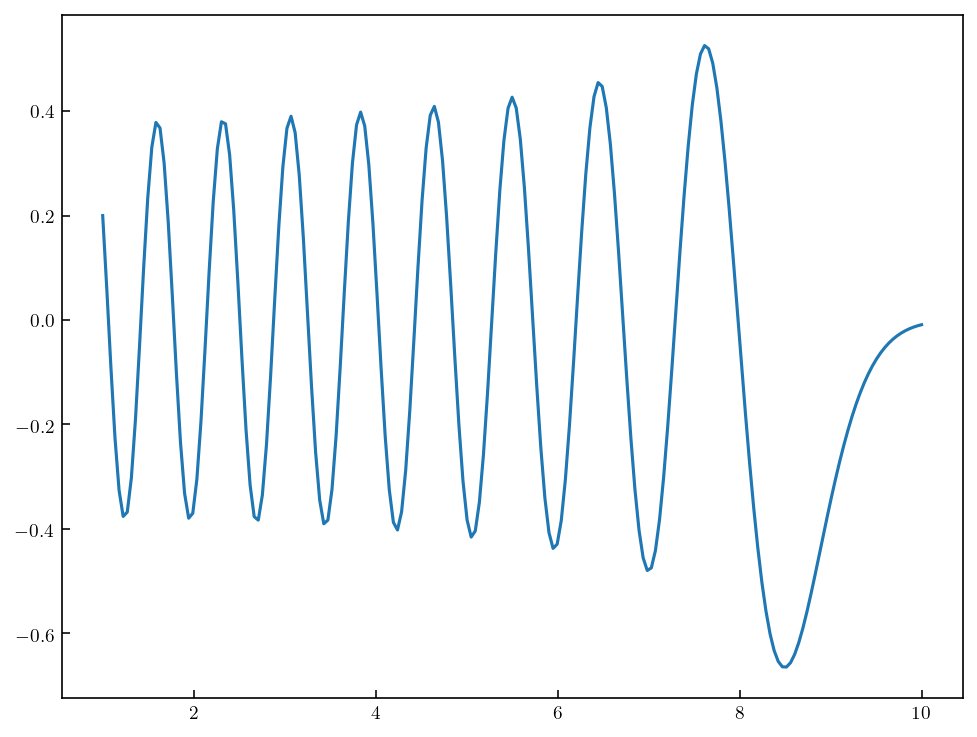

In [5]:
u_nl = ho_radial_wf(r_grid, n=20, ell=0, b=1)
plt.plot(r_grid, u_nl)

In [6]:
r, dr = compound_mesh('0 1 3 5 10', '50 50 50 50 50')

In [7]:
u_nl_quad = ho_radial_wf(r, n=3, ell=5, b=1)
np.sum(u_nl_quad**2 * dr)

1.0000000000000016

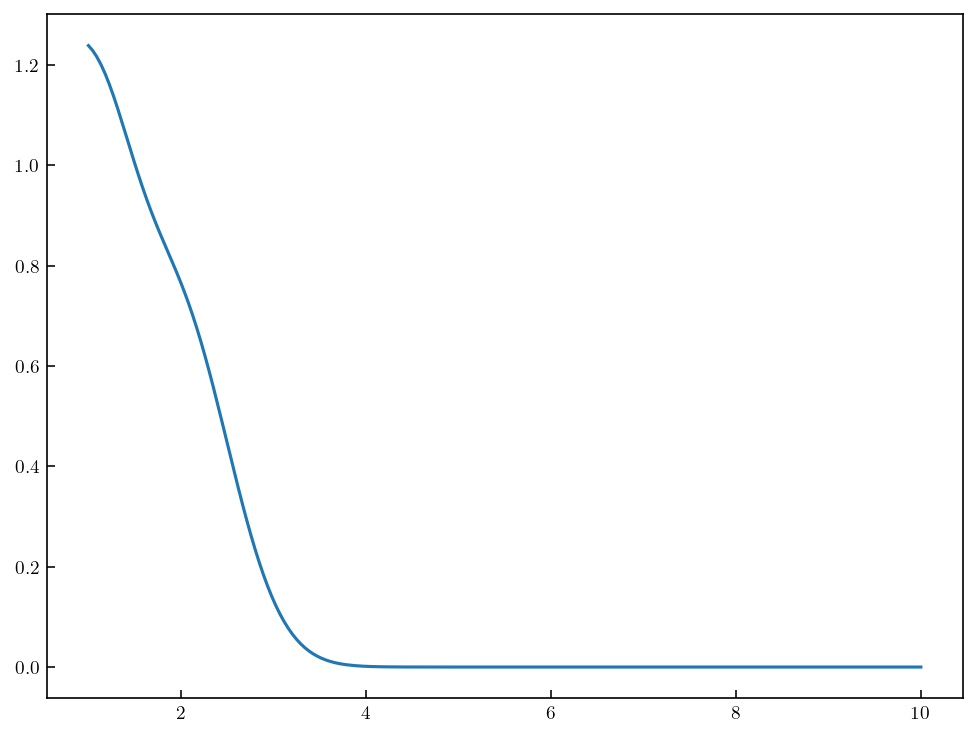

In [8]:
rho_ho = ho_density(r_grid, n_max=4, g=2, b=1)
plt.plot(r_grid, rho_ho)

In [9]:
a_s = -0.16
a_p = 0
r_s = 0

trap_lo = HarmonicTrap(
    r=r, dr=dr, mass=1, b=1, g=2,
    n_max_shell=7, n_max_osc=30,
    kind='lo'
)
trap_nlo = HarmonicTrap(
    r=r, dr=dr, mass=1, b=1, g=2,
    n_max_shell=7, n_max_osc=30,
    kind='nlo', damping_factor=0.9
)
trap_nnlo = HarmonicTrap(
    r=r, dr=dr, mass=1, b=1, g=2,
    n_max_shell=7, n_max_osc=10,
    kind='nnlo'
)
trap_harm = HarmonicTrap(
    r=r, dr=dr, mass=1, b=1, g=2,
    n_max_shell=7, n_max_osc=10,
    kind='harmonic'
)

In [10]:
params = [a_s, a_p, r_s]

In [11]:
a_s

-0.16

In [12]:
tol = 1e-5
rho_lo_pred = trap_lo.predict(params, tolerance=tol)
rho_nlo_pred = trap_nlo.predict(params, tolerance=tol)
rho_nnlo_pred = trap_nnlo.predict(params, tolerance=tol)
rho_harm_pred = trap_harm.predict([1], tolerance=tol, verbose=True)

It took 50 iterations to converge
The error is 8.807418300449399e-06


In [13]:
trap_harm.fit([[0], [1]])

In [14]:
r_max_plot = 5

In [15]:
C0_pred = 0.5
rho_harm_full = trap_harm.predict([C0_pred], use_emulator=False)
rho_harm_emul, result = trap_harm.predict([C0_pred], use_emulator=True, verbose=False, tolerance=1e-10)
result

      fun: 1653.9405686097587
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 10
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([-4.99102237])

In [16]:
trap_nlo.fit([[-0.3], [0.1], [0.2]])

In [17]:
%%timeit
trap_nlo.predict(params, use_emulator=False, verbose=False, tolerance=1e-2)

2.68 s ± 266 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%%timeit
trap_nlo.predict(params, use_emulator=True, verbose=False, tolerance=1e-2)

556 ms ± 118 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
rho_nlo_emul, result = trap_nlo.predict(params, use_emulator=True, verbose=False, tolerance=1e-2)
result

      fun: 1501.0915643334783
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.7240609 , 0.68177996])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 9
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([1.03325434, 0.62154595])

In [22]:
from dft.graphs import PRED_KWARGS, FULL_KWARGS

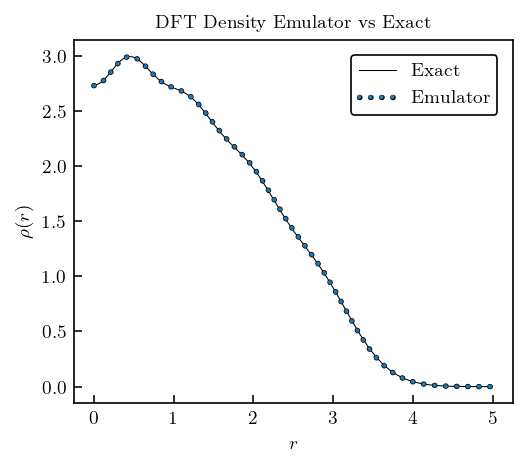

In [29]:
fig, ax = plt.subplots(figsize=(3.4, 3))
ax.plot(r[r<r_max_plot], rho_nlo_pred[r<r_max_plot], label='Exact', **FULL_KWARGS)

# for ii in np.linspace(1.2, 1.3, 100):
#     rho_nlo_emul = trap_nlo.rho_train @ np.array([ii, 1-ii])
#     plt.plot(r[r<r_max_plot], rho_nlo_emul[r<r_max_plot], zorder=-1)
    
# rho_nlo_emul = trap_nlo.rho_train @ np.array([1.23, 1-1.23])
ax.plot(r[r<r_max_plot], rho_nlo_emul[r<r_max_plot], label='Emulator', **PRED_KWARGS)
# ax.set_ylim(-5, 5)
ax.legend()
# ax.set_title(fr"NLO Density at $a_s = {a_s}$")
ax.set_title(fr"DFT Density Emulator vs Exact")
ax.set_xlabel("$r$")
ax.set_ylabel(r"$\rho(r)$")
fig.savefig('dft_nlo_example.png')

In [521]:
rho_harm_full = trap_harm.predict([C0_pred], use_emulator=False)
rho_harm_emul, result = trap_harm.predict([C0_pred], use_emulator=True, verbose=False, tolerance=1e-10)

In [522]:
result

      fun: 1813.2494881225525
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([-5.13010736])

In [471]:
trap_harm.energy([C0_pred], rho=rho_harm_emul)

1719.8597807705696

In [446]:
trap_harm.energy([C0_pred], rho=trap_harm.rho_train @ np.array([0.02, 1-0.02]))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 3)

In [436]:
trap_harm.energy([C0_pred], rho=rho_harm_full)

1725.995398325231

(-5.0, 5.0)

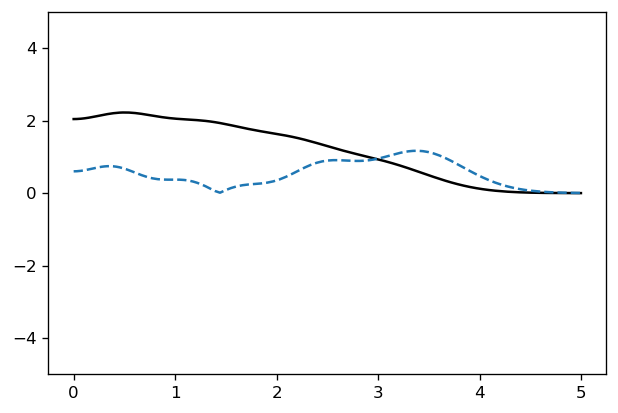

In [524]:

plt.plot(r[r<r_max_plot], rho_harm_full[r<r_max_plot], c='k', zorder=0)

# plt.plot(r[r<r_max_plot], rho_harm_emul[r<r_max_plot]/rho_harm_emul[0]*rho_harm_full[0])
# for ii in np.linspace(-0, 0.1, 100):
#     rho_harm_emul = trap_harm.rho_train @ np.array([ii, 1-ii])
#     plt.plot(r[r<r_max_plot], rho_harm_emul[r<r_max_plot], zorder=-1)
    
# rho_harm_emul = trap_harm.rho_train @ np.array([0.02, 1-0.02])
plt.plot(r[r<r_max_plot], rho_harm_emul[r<r_max_plot], ls='--')
plt.ylim(-5, 5)

In [309]:
e_lo_full = trap_lo.energy(params)
e_nlo_full = trap_nlo.energy(params)
e_nnlo_full = trap_nnlo.energy(params)

0 [-1.64140418  0.96879176  3.49512372  5.92454585]
1 [-0.3195782   2.25017493  4.73063759  7.10406666]
2 [0.98871137 3.51618188 5.9473954 ]
3 [2.28335887 4.76622607 7.1436177 ]
4 [3.56387198 5.99924219]
5 [4.82961908 7.21377898]
6 [6.07982638]
7 [7.31353372]
1217.8859536410912
0 [-0.02987357  2.19636978  4.42094441  6.63104223]
1 [1.08235811 3.30936728 5.52938496 7.72424728]
2 [2.19530165 4.4212492  6.63343527]
3 [3.3085659  5.53128781 7.73093491]
4 [4.42170149 6.63853311]
5 [5.53419145 7.74163523]
6 [6.64542394]
7 [7.75464031]
1393.372654522923
0 [-0.19798513  2.07129586  4.32708108  6.55824405]
1 [0.93844742 3.2023722  5.44817137 7.6596079 ]
2 [2.07344401 4.33041953 6.56337414]
3 [3.206703   5.4548333  7.67058579]
4 [4.33783057 6.57478455]
5 [5.46637189 7.68900288]
6 [6.59178257]
7 [7.71337505]
1375.9638664652152


In [307]:
e_harm_full = trap_harm.energy([0])

0 [1.5 3.5 5.5 7.5]
1 [2.5 4.5 6.5 8.5]
2 [3.5 5.5 7.5]
3 [4.5 6.5 8.5]
4 [5.5 7.5]
5 [6.5 8.5]
6 [7.5]
7 [8.5]
1620.0


In [308]:
e_harm_full / 240

6.75

In [310]:
e_lo_full / 240

5.981616832016363

In [311]:
e_nlo_full / 240

6.2536466242421875

In [312]:
e_nnlo_full / 240

6.228690839159777

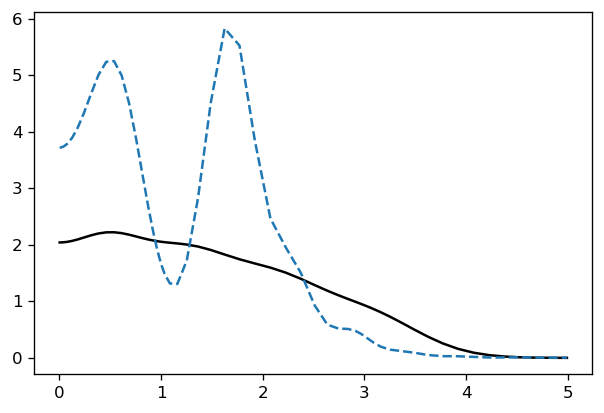

In [44]:
fig, ax = plt.subplots()
ax.plot(r[r<r_max_plot], rho_harm_full[r<r_max_plot], label=r'Exact', c='k')
ax.plot(r[r<r_max_plot], rho_harm_emul[r<r_max_plot], label=r'EC', ls='--')

In [258]:
import matplotlib.ticker as ticks

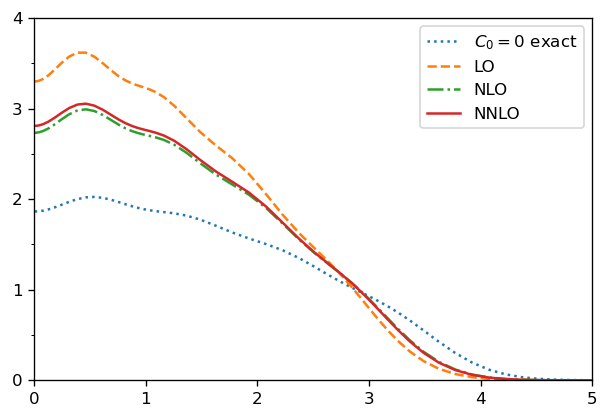

In [292]:


fig, ax = plt.subplots()
ax.plot(r[r<r_max_plot], rho_harm_pred[r<r_max_plot], label=r'$C_0=0$ exact', ls=':')
ax.plot(r[r<r_max_plot], rho_lo_pred[r<r_max_plot], label='LO', ls='--')
ax.plot(r[r<r_max_plot], rho_nlo_pred[r<r_max_plot], label='NLO', ls='-.')
ax.plot(r[r<r_max_plot], rho_nnlo_pred[r<r_max_plot], label='NNLO')
ax.legend()
ax.set_ylim(0, 4)
# ax.set_ylim(0, 3)
ax.set_xlim(0, 5)
ax.yaxis.set_major_locator(ticks.MaxNLocator(4))
# ax.yaxis.set_major_locator(ticks.MaxNLocator(3))
ax.yaxis.set_minor_locator(ticks.AutoMinorLocator(2))

In [45]:
from dft.solvers import Emulator

In [154]:
n_params_test

3

In [176]:
rng = np.random.default_rng(2)
n_params_test = 3
xx_test = np.linspace(0, 5, 101)
# H0_test = rng.uniform(size=(100, 100))
# H0_test += H0_test.T + 1 * np.eye(100)
H0_test = -np.exp(-(xx_test - xx_test[:, None])**2)


# H1_test = rng.uniform(size=(100, 100, n_params_test))
# H1_test += H1_test.transpose((1, 0, 2))
H1_test = -np.dstack([np.exp(-np.abs(xx_test - xx_test[:, None])**(n/2)) for n in range(1, n_params_test+1)])

In [177]:
H1_test.shape

(101, 101, 3)

In [197]:
em = Emulator(H0=H0_test, H1=H1_test, n_max_vec=7)

In [247]:
em.fit(rng.normal(scale=5, size=(13, n_params_test)), max_vecs=2)

In [248]:
p_eval_test = np.zeros(n_params_test)

In [249]:
e_test_full, wf_test_full = em.predict(p_eval_test, use_emulator=False)
e_test_pred, wf_test_pred = em.predict(p_eval_test, use_emulator=True)

In [250]:
em.X_sub.shape

(101, 26)

In [251]:
np.max(wf_test_full-wf_test_pred)

0.3903980117210455

In [252]:
e_test_full - e_test_pred, e_test_full, e_test_pred

(-0.0003012975984387767, -0.4787156167138411, -0.47841431911540233)

Text(0.5, 1.0, 'Wave functions (absolute value)')

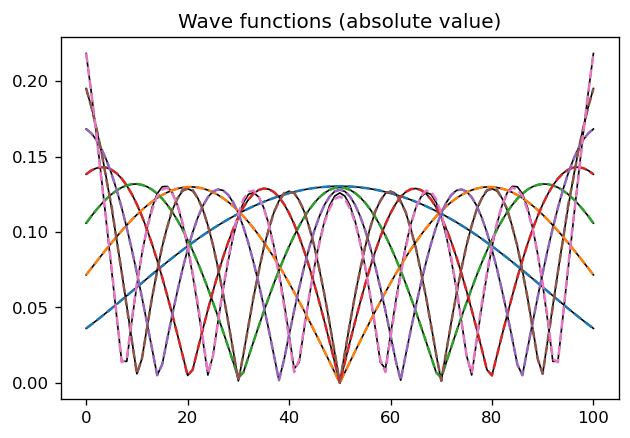

In [255]:
fig, axes = plt.subplots()
plt.plot(np.abs(wf_test_full), c='k', lw=1)
plt.plot(np.abs(wf_test_pred), ls='--')
plt.title("Wave functions (absolute value)")

Text(0.5, 1.0, 'Residuals')

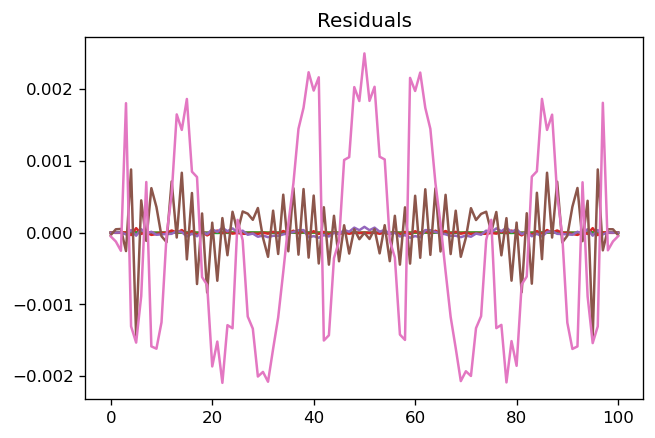

In [256]:
fig, axes = plt.subplots()
plt.plot(np.abs(wf_test_full)-np.abs(wf_test_pred))
# plt.plot(wf_test_pred, ls='--')
plt.title("Residuals")